# GNN Notebook

This notebook loads functions from ```model_training.py``` to train and generate predictions for GNN trained on the lattice data.


Author:
Alexandra Haslund-Gourley

Date:
March 21 2025




In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import torch

if torch.cuda.is_available():
    print("GPU is available:", torch.cuda.get_device_name(0))
else:
    print("No GPU found. Using CPU.")

Mounted at /content/drive/
GPU is available: Tesla T4


In [2]:
! pip install ase
! pip install dscribe
! pip install torch_geometric


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys

path = ""
sys.path.append(path)
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view
from ase.visualize.plot import plot_atoms

from sklearn.model_selection import train_test_split
import torch

# import our libraries
import importlib
import model_training as mt


import os
import pandas as pd
import json

df = pd.DataFrame(json.load(open(f"{path}data.json", 'rb')))

#transform the data into ASE
df.atoms = df.atoms.apply(lambda x: Atoms(**x))

df['n_atoms'] = df.atoms.apply(lambda x: len(x.get_chemical_symbols()))
df['CM'] = df.atoms.apply(mt.gen_CM, reshape = True)


def gen_train_test_val(df, n_samples):
    df_to_use = df.iloc[np.random.randint(0, len(df), n_samples)]
    print("len of df_to_use", len(df_to_use))
    # Proper train/test split
    test_df ,train_df = train_test_split(df_to_use, test_size=0.75, random_state=42)
    # Then create validation set from training data
    test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=42)
    return train_df, test_df, val_df

def threshold_CM(CM, threshold=None):
    """
    Remove small values from the Coulomb matrix
    """
    if threshold is None:
        threshold = 1e-3 * CM.max()
    CM[CM < threshold] = 0
    return CM

# define the training and test data:
n_samples = len(df)
train_df, test_df, val_df = gen_train_test_val(df, n_samples)

# apply the thresholding to teh CM matrix
train_df.CM = train_df.CM.apply(threshold_CM, 1)
test_df.CM = test_df.CM.apply(threshold_CM, 1)
val_df.CM = val_df.CM.apply(threshold_CM, 1)


len of df_to_use 12096
len of train_df 9072
len of test_df 1512
len of val_df 1512
len of df_to_use 12096


<ipython-input-5-8170f9470cf8>:71: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  train_df.CM = train_df.CM.apply(threshold_CM, 1)
<ipython-input-5-8170f9470cf8>:72: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  test_df.CM = test_df.CM.apply(threshold_CM, 1)
<ipython-input-5-8170f9470cf8>:73: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  val_df.CM = val_df.CM.apply(threshold_CM, 1)


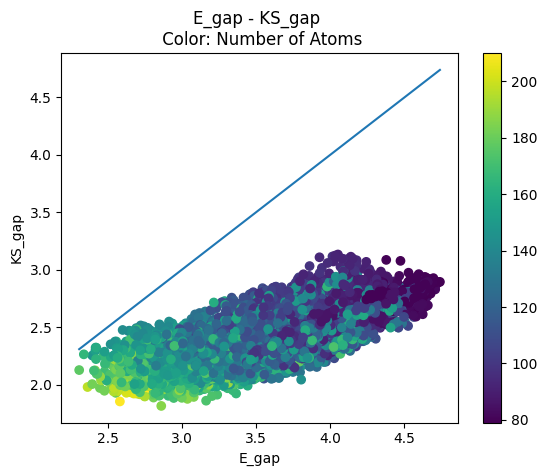

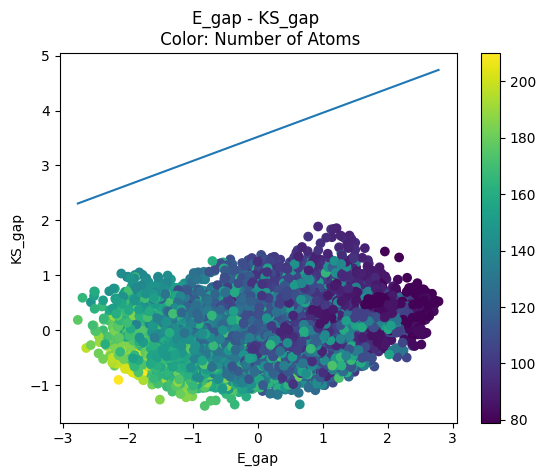

In [ ]:
plt.scatter(df.E_gap, df.E_gap-df.KS_gap, c = df.n_atoms)
plt.plot([min(df.E_gap), max(df.E_gap)],[min(df.E_gap), max(df.E_gap)])
plt.xlabel('E_gap')
plt.ylabel('KS_gap')
plt.title('E_gap - KS_gap \n Color: Number of Atoms')
plt.colorbar()
plt.show()

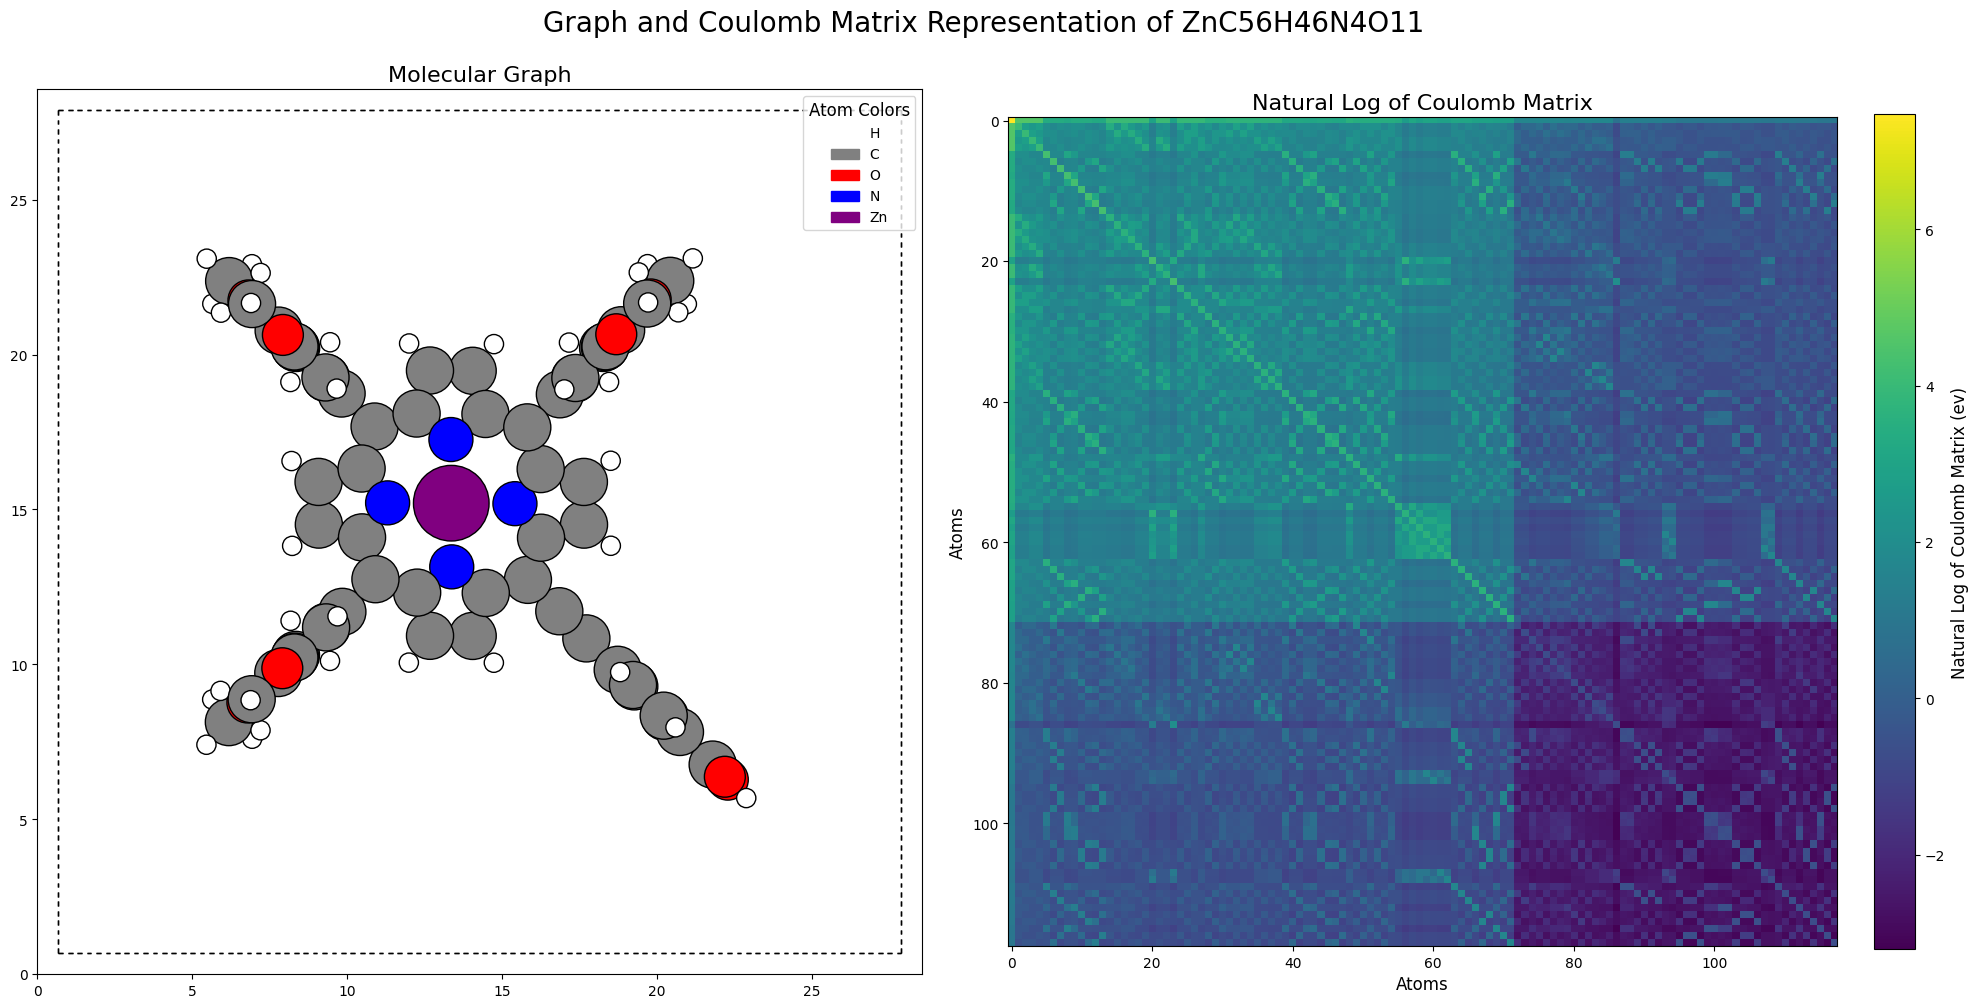

In [ ]:
import matplotlib.patches as mpatches

# Define a color key for atoms
atom_colors = {
    "H": "white",
    "C": "grey",
    "O": "red",
    "N": "blue",
    # "S": "yellow",
    # "Cl": "green",
    "Zn": "purple",

    # Add more elements as needed
}

# Create a legend for the atom color key
def add_atom_color_key(ax):
    patches = [mpatches.Patch(color=color, label=atom) for atom, color in atom_colors.items()]
    ax.legend(handles=patches, title="Atom Colors", loc="upper right", fontsize=10, title_fontsize=12)

# Plot the graph
fig, ax = plt.subplots(ncols=2, figsize=(20, 10))

# Plot the molecule
plot_atoms(df.atoms.iloc[0], ax=ax[0], colors  = [atom_colors[atom] for atom in df.atoms.iloc[0].get_chemical_symbols()])
ax[0].set_title(f"Molecular Graph", fontsize=16)
add_atom_color_key(ax[0])  # Add the atom color key to the molecule plot

# Plot the Coulomb matrix
coulomb_matrix = np.log(df.CM.iloc[0])  # Log of Coulomb matrix
im = ax[1].imshow(coulomb_matrix, cmap="viridis")
ax[1].set_title("Natural Log of Coulomb Matrix", fontsize=16)
ax[1].set_xlabel("Atoms", fontsize=12)
ax[1].set_ylabel("Atoms", fontsize=12)

# Add a color bar for the Coulomb matrix
cbar = fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04,)
cbar.set_label("Natural Log of Coulomb Matrix (ev)", fontsize=12)

# Adjust layout for better formatting
plt.tight_layout()
plt.suptitle(f"Graph and Coulomb Matrix Representation of {df.iloc[0].formula}", fontsize=20)
plt.subplots_adjust(top=0.9)
plt.savefig(f"{path}molecule_graph.png")
plt.show()

BASE MODEL


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Prepared dataset with 9072 samples


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Created data loaders
Generating model with hidden dim: 64
Training with epochs: 150
Learning rate: 0.005

Gradient Statistics:
  conv average gradient magnitude: 0.00282
  conv max gradient magnitude: 0.05889
  energy_predictor average gradient magnitude: 0.15961
  energy_predictor max gradient magnitude: 2.50559
  KS_gap_predictor average gradient magnitude: 0.12349
  KS_gap_predictor max gradient magnitude: 3.56055
  E_gap_predictor average gradient magnitude: 0.13865
  E_gap_predictor max gradient magnitude: 2.03410
Epoch 1/150, Train Loss: 2.5105, Energy Loss: 0.7351, KS_gap Loss: 0.9241, E_gap Loss: 0.8513, Test MSE: Energy=0.4782, KS_gap=0.7617, E_gap=0.7386

Gradient Statistics:
  conv average gradient magnitude: 0.00304
  conv max gradient magnitude: 0.04057
  energy_predictor average gradient magnitude: 0.16695
  energy_predictor max gradient magnitude: 1.88686
  KS_gap_predictor average gradient magnitude: 0.14694
  KS_gap_predictor max gradient magnitude: 1.97191
  E_gap_pre

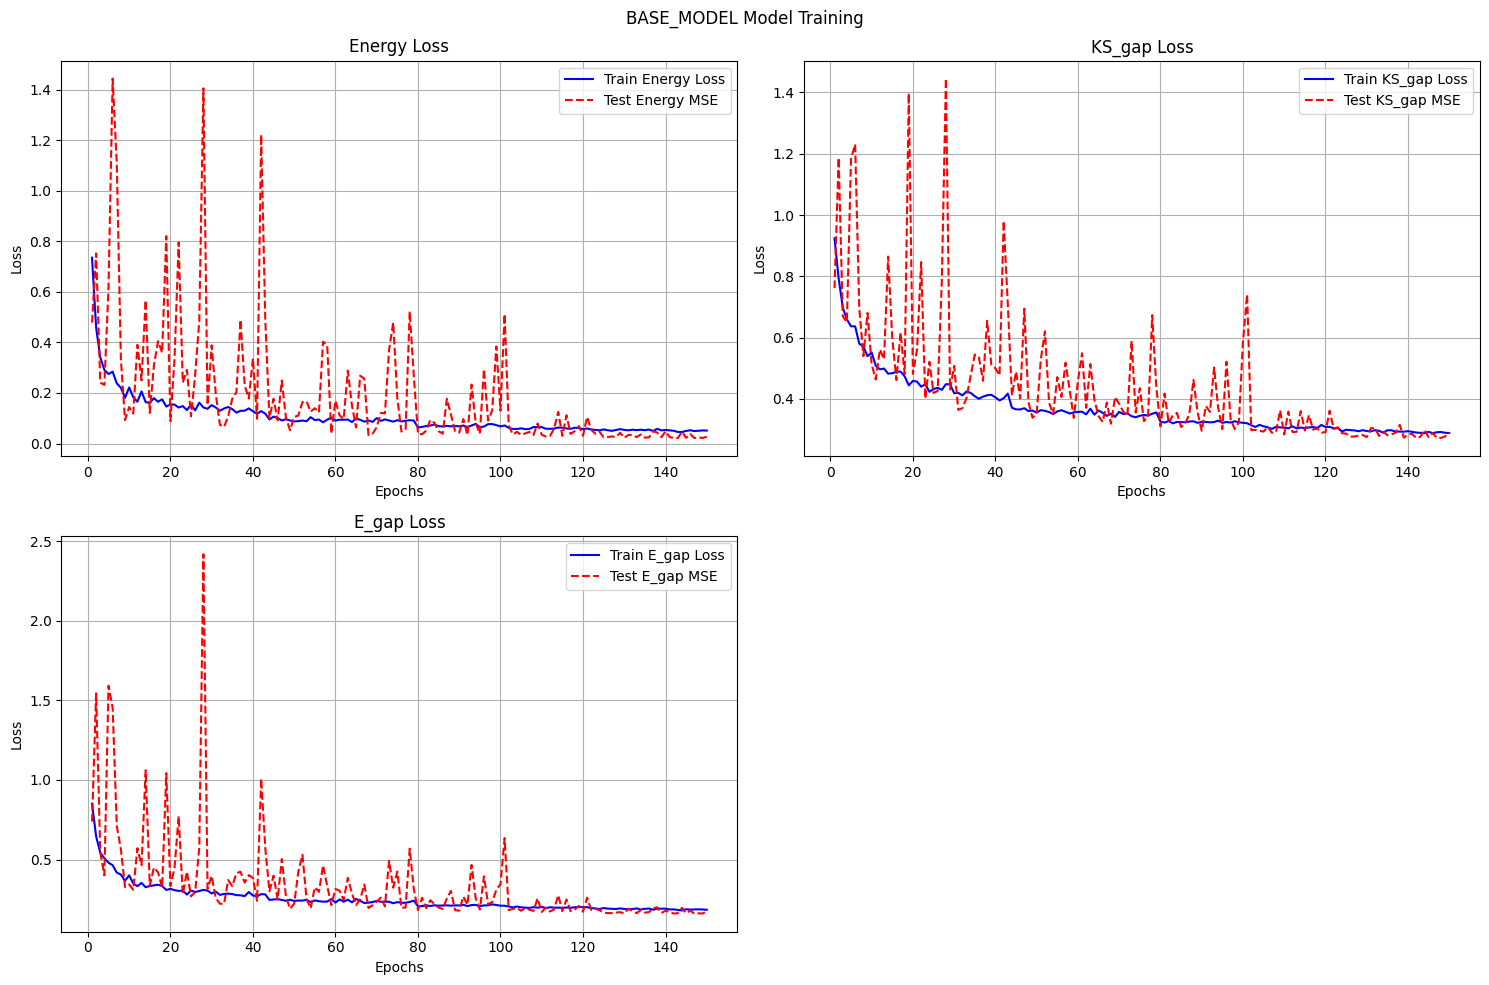

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Batch prediction results:
      energy_pred  KS_gap_pred  E_gap_pred  energy_true  KS_gap_true  \
0    -1006.144409     1.095497    3.505408  -979.310271     0.875498   
1     -565.830566     1.506729    4.264078  -537.053729     1.510451   
2     -569.772461     1.624402    4.332208  -575.066543     1.745238   
3     -989.453430     1.029113    3.230986 -1009.883590     1.192694   
4     -926.331726     1.422346    3.921040  -916.105221     1.406430   
...           ...          ...         ...          ...          ...   
1507  -966.014038     1.015277    3.402663  -935.103182     0.955636   
1508  -760.861572     1.269898    3.719033  -749.786684     1.345304   
1509 -1077.741821     1.166811    3.504959 -1084.909723     1.249823   
1510  -773.654541     1.062552    3.470335  -780.523726     1.329247   
1511  -949.530212     1.458613    4.011212  -936.058166     1.497005   

      E_gap_true  physics_valid  physics_violation  
0       3.468918           True                0.0  
1  

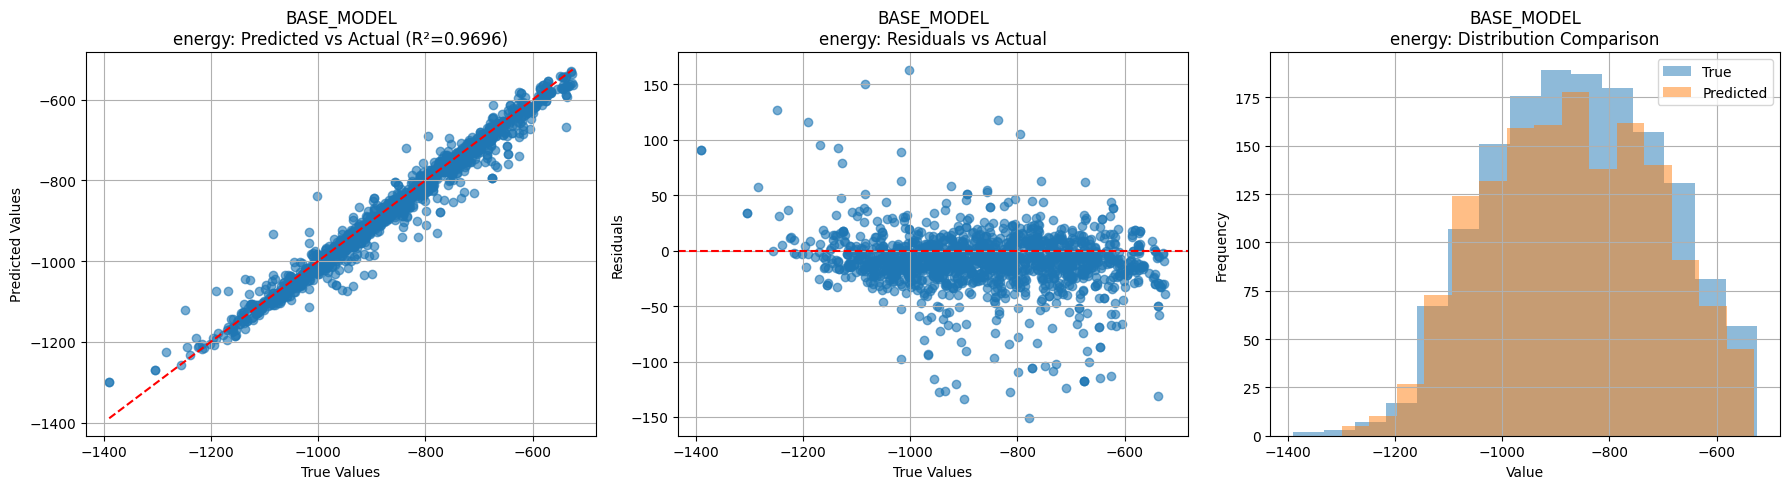

=== KS_gap Evaluation ===
Data range: 0.1224 to 1.9200 (span: 1.7976)
Mean value: 1.1388
MSE: 0.028287
RMSE: 0.168186
MAE: 0.132911
R²: 0.7211
NMSE (normalized by variance): 0.2789
Error as % of data range: 7.39%
Improvement over mean baseline: 72.11%


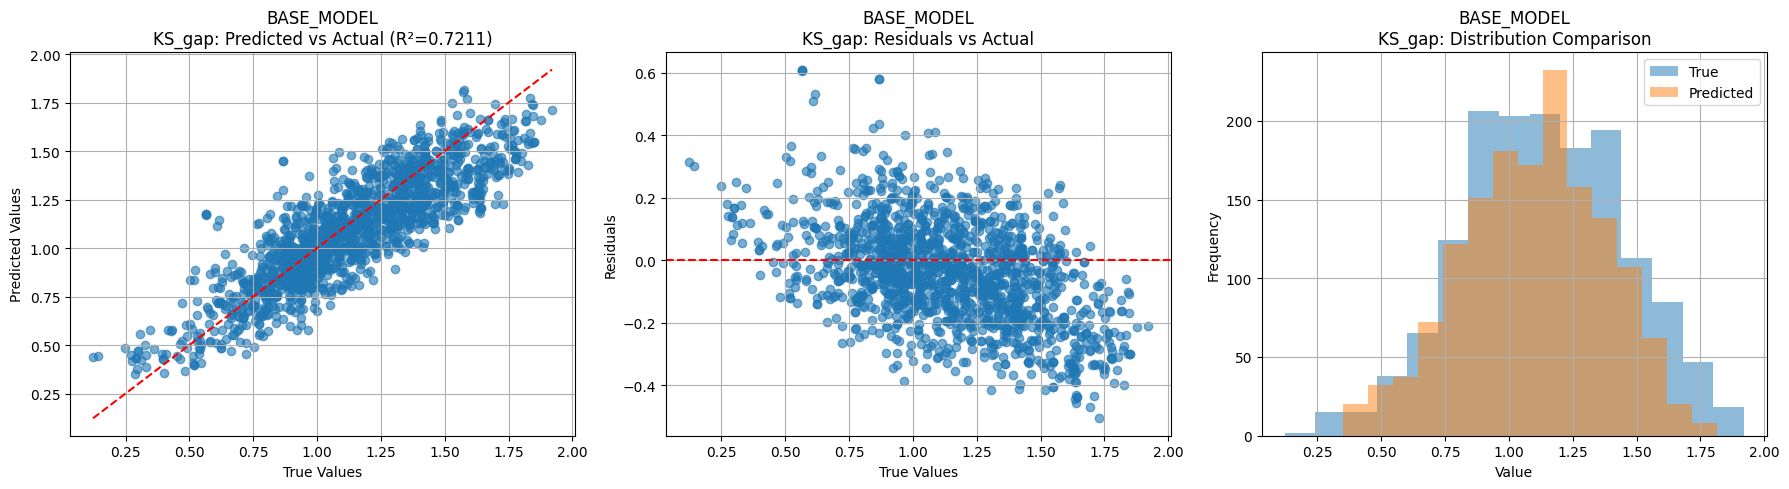

=== E_gap Evaluation ===
Data range: 2.3965 to 4.7251 (span: 2.3286)
Mean value: 3.5410
MSE: 0.034443
RMSE: 0.185587
MAE: 0.146869
R²: 0.8214
NMSE (normalized by variance): 0.1786
Error as % of data range: 6.31%
Improvement over mean baseline: 82.14%


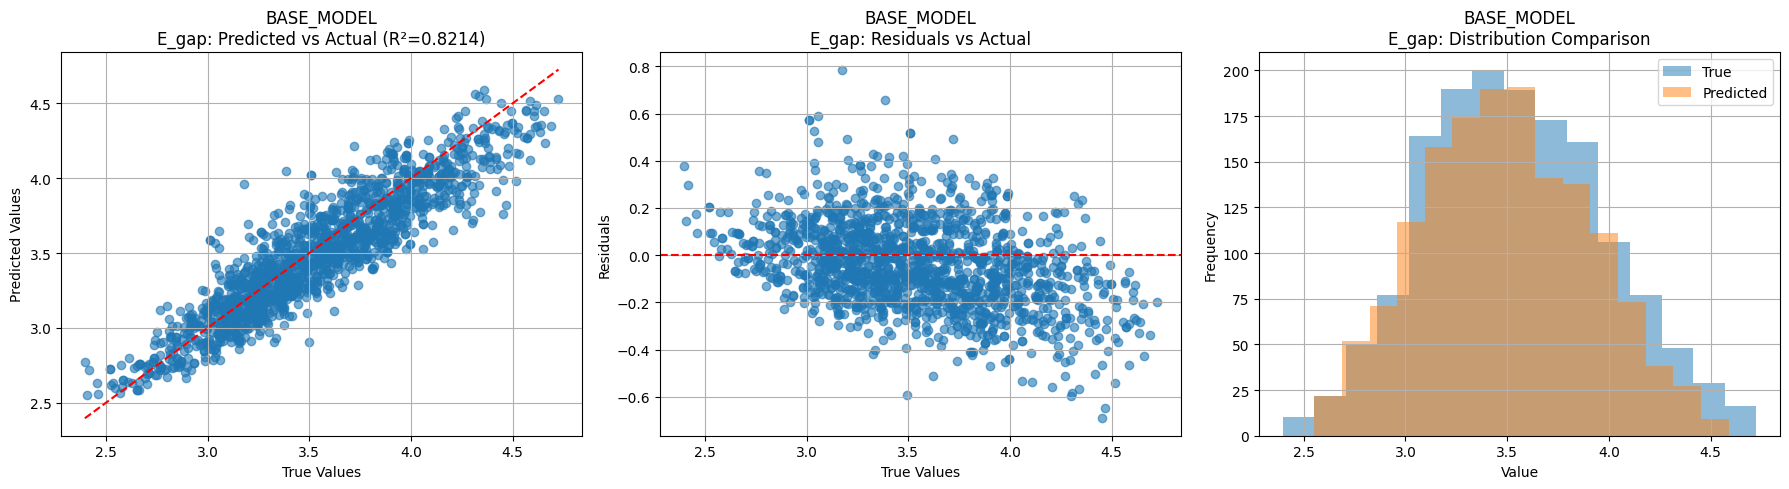

In [19]:
print("BASE MODEL")

save_directory = f"{path}model_outputs/"

# ensure that the directory exists
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

importlib.reload(mt)
test_name = "BASE_MODEL"
config = {'batch_size': 32, 'epochs': 150, 'lr': 0.005, 'physics_loss_weight': 0,'nll_loss_weight': 0, 'save_path': f"{save_directory}",'save_path_model': f"{save_directory}/{test_name}_best_model.pt", 'title': test_name}
model, train_metrics, test_metrics,scalers = mt.run_training(train_df, test_df, batch_size=config['batch_size'], epochs=config['epochs'], lr=config['lr'], physics_loss_weight = config['physics_loss_weight'], nll_loss_weight = config['nll_loss_weight'], save_path=config['save_path_model'], title = config['title'])

print("Trained model")
print("Running with the following metrics:")
print(train_metrics)
print(test_metrics)

metrics_df = pd.DataFrame([train_metrics, test_metrics], columns=['Train Metrics' 'Test Metrics'])
metrics_df.to_csv(f"{config['save_path']}{config['title']}_metrics_df.csv")

mt.plot_training_performance(train_metrics, test_metrics, save_path=f"{config['save_path']}{config['title']}_model_training.png", title=f"{config['title']} Model Training")

# Load best model for inferencex
best_model = mt.GraphNet(node_dim=1, edge_dim=1, hidden_dim=64, output_dim=1)
best_model.load_state_dict(torch.load(config['save_path_model']))

# Example: Run inference on the whole holdout set
best_model = mt.load_model(config['save_path_model'])
results_df = mt.predict_batch_properties(best_model, val_df,scalers)
results_df.to_csv(f"{config['save_path']}{config['title']}_results_df.csv")
print("Batch prediction results:")
print(results_df)

# Usage example
# For each property:
data_to_save = []
for prop in ['energy', 'KS_gap', 'E_gap']:
    true_col = f'{prop}_true'
    pred_col = f'{prop}_pred'

    if true_col in results_df.columns:
        feature_metrics = mt.comprehensive_evaluation(
            results_df[true_col].values,
            results_df[pred_col].values,
            property_name=prop,
            run_name=test_name,
            save_path=f"{config['save_path']}_{config['title']}_{prop}_evaluation.png",
        )
    data_to_save.append([prop, feature_metrics])

# save the data to save  to file
data_to_save_df = pd.DataFrame(data_to_save, columns=['Property', 'Metrics'])
data_to_save_df.to_csv(f"{config['save_path']}{config['title']}_feature_metrics.csv")


PHYSICS CONSTRAINT 1 MODEL


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Prepared dataset with 9072 samples


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Created data loaders
Generating model with hidden dim: 64
Training with epochs: 150
Learning rate: 0.005

Gradient Statistics:
  conv average gradient magnitude: 0.00363
  conv max gradient magnitude: 0.13584
  energy_predictor average gradient magnitude: 0.15292
  energy_predictor max gradient magnitude: 3.16127
  KS_gap_predictor average gradient magnitude: 0.14920
  KS_gap_predictor max gradient magnitude: 3.47773
  E_gap_predictor average gradient magnitude: 0.16353
  E_gap_predictor max gradient magnitude: 2.97143
Epoch 1/150, Train Loss: 2.5237, Energy Loss: 0.7459, KS_gap Loss: 0.9213, E_gap Loss: 0.8565, Test MSE: Energy=0.5447, KS_gap=0.8587, E_gap=0.7303

Gradient Statistics:
  conv average gradient magnitude: 0.00402
  conv max gradient magnitude: 0.03739
  energy_predictor average gradient magnitude: 0.14982
  energy_predictor max gradient magnitude: 1.86637
  KS_gap_predictor average gradient magnitude: 0.12099
  KS_gap_predictor max gradient magnitude: 1.42547
  E_gap_pre

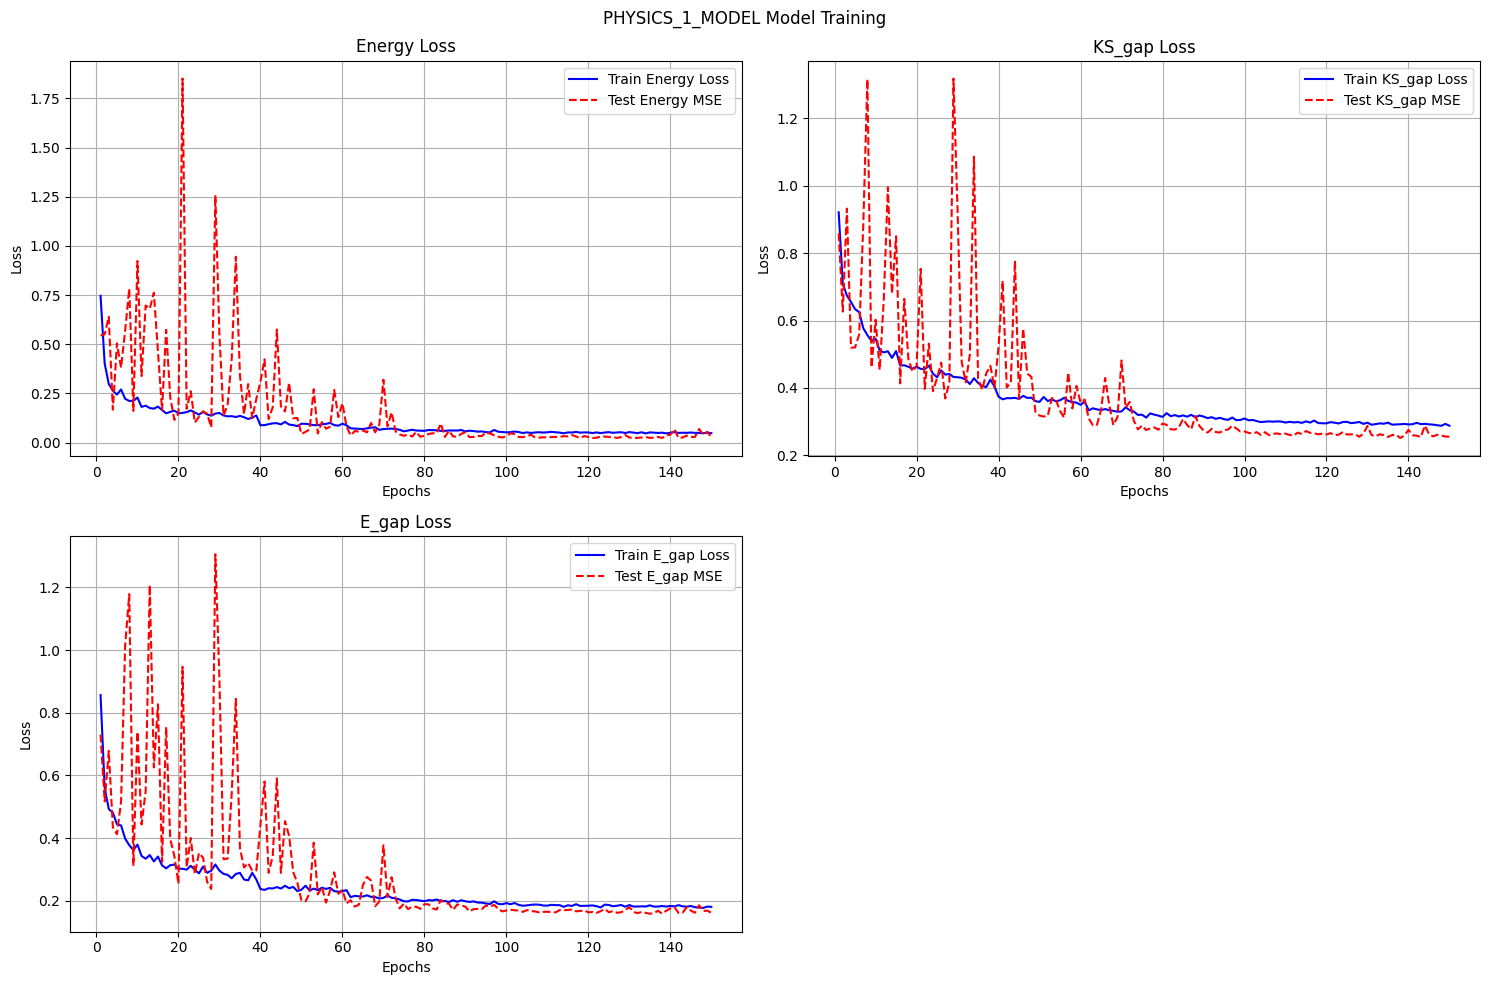

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Batch prediction results:
      energy_pred  KS_gap_pred  E_gap_pred  energy_true  KS_gap_true  \
0     -567.142395     1.499078    4.236119  -563.309095     1.623173   
1     -951.948242     1.079066    3.309588  -943.433762     1.008035   
2     -606.871582     1.530613    4.235903  -578.672957     1.557047   
3     -809.527954     1.247118    3.505298  -816.404388     1.283090   
4    -1022.017761     0.931054    3.236030  -983.286795     1.345429   
...           ...          ...         ...          ...          ...   
1507  -573.620911     1.591913    4.339900  -550.219892     1.531837   
1508 -1221.043335     1.073255    3.146158 -1242.847288     1.180622   
1509 -1090.443604     1.052122    3.243628 -1086.479449     1.125403   
1510  -693.120239     1.300203    3.883147  -679.815496     1.195911   
1511  -840.046570     0.898857    3.243926  -852.353412     0.900791   

      E_gap_true  physics_valid  physics_violation  
0       4.367629           True                0.0  
1  

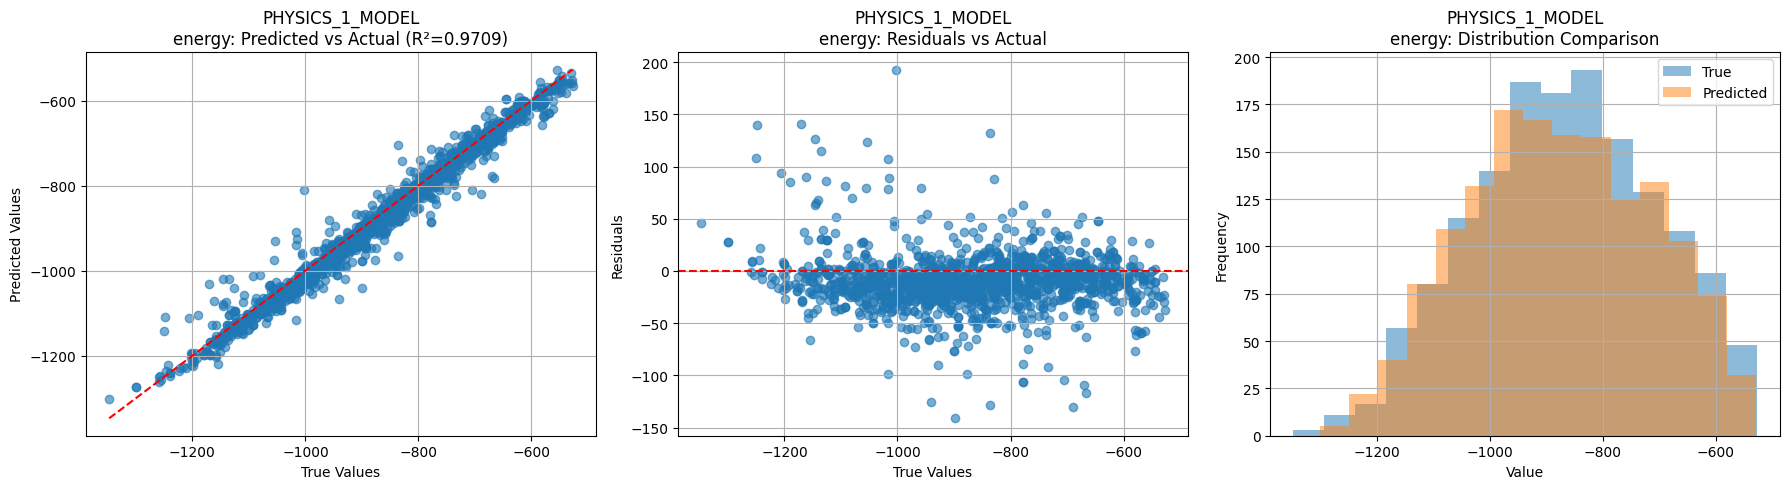

=== KS_gap Evaluation ===
Data range: 0.1257 to 1.9583 (span: 1.8326)
Mean value: 1.1287
MSE: 0.026259
RMSE: 0.162045
MAE: 0.127698
R²: 0.7424
NMSE (normalized by variance): 0.2576
Error as % of data range: 6.97%
Improvement over mean baseline: 74.24%


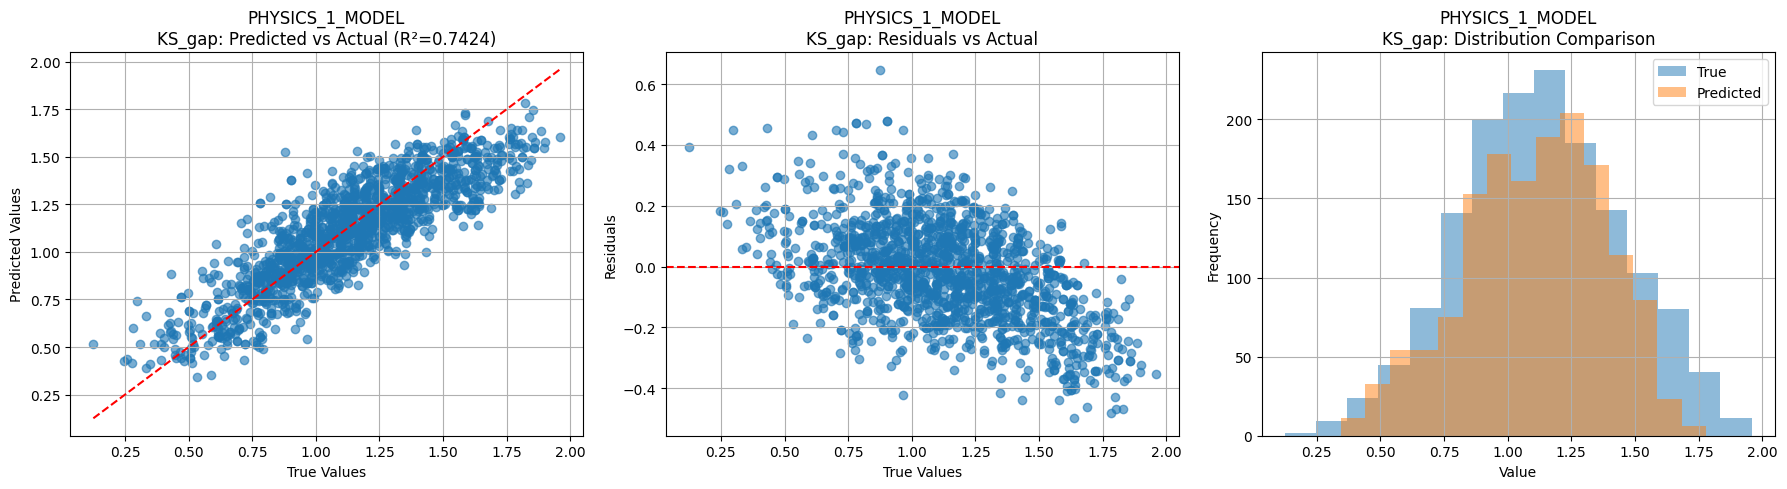

=== E_gap Evaluation ===
Data range: 2.4784 to 4.6953 (span: 2.2168)
Mean value: 3.5189
MSE: 0.030920
RMSE: 0.175841
MAE: 0.139389
R²: 0.8443
NMSE (normalized by variance): 0.1557
Error as % of data range: 6.29%
Improvement over mean baseline: 84.43%


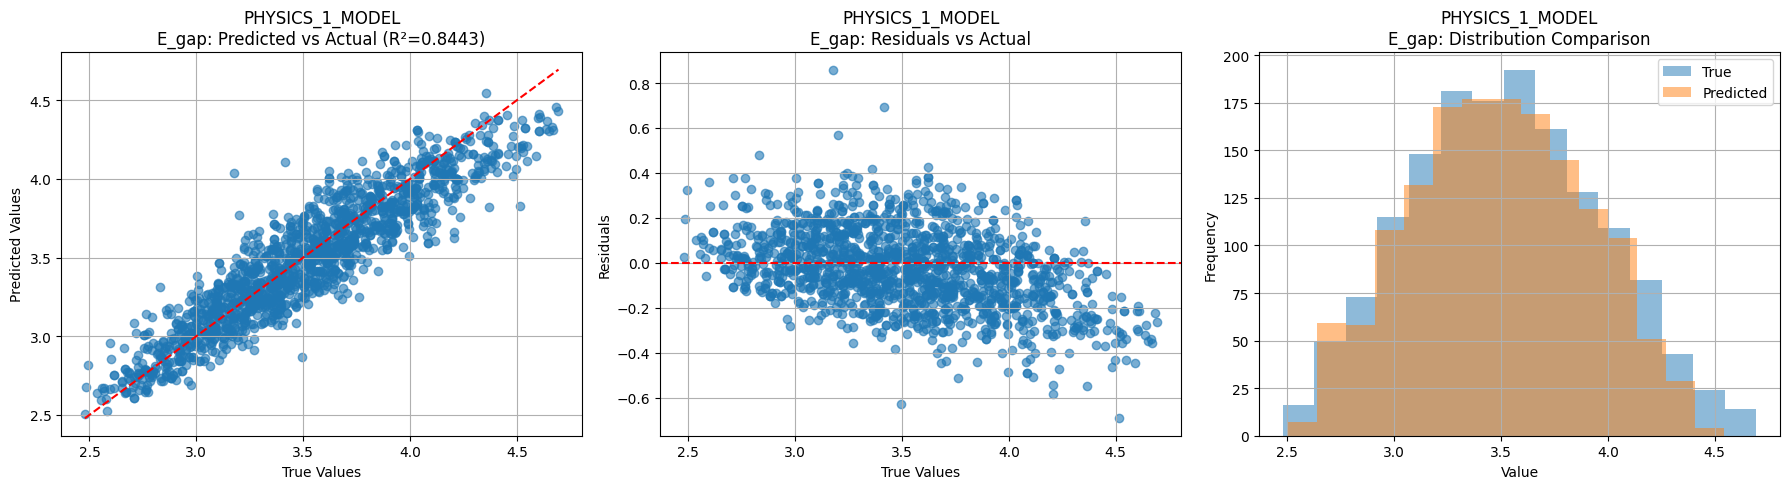

In [6]:
print("PHYSICS CONSTRAINT 1 MODEL")

save_directory = f"{path}model_outputs/"

# ensure that the directory exists
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

importlib.reload(mt)
test_name = "PHYSICS_1_MODEL"
config = {'batch_size': 32, 'epochs': 150, 'lr': 0.005, 'physics_loss_weight': .2,'nll_loss_weight': 0, 'save_path': f"{save_directory}",'save_path_model': f"{save_directory}/{test_name}_best_model.pt", 'title': test_name}
model, train_metrics, test_metrics,scalers = mt.run_training(train_df, test_df, batch_size=config['batch_size'], epochs=config['epochs'], lr=config['lr'], physics_loss_weight = config['physics_loss_weight'], nll_loss_weight = config['nll_loss_weight'], save_path=config['save_path_model'], title = config['title'])

print("Trained model")
print("Running with the following metrics:")
print(train_metrics)
print(test_metrics)

metrics_df = pd.DataFrame([train_metrics, test_metrics], columns=['Train Metrics' 'Test Metrics'])
metrics_df.to_csv(f"{config['save_path']}{config['title']}_metrics_df.csv")

mt.plot_training_performance(train_metrics, test_metrics, save_path=f"{config['save_path']}{config['title']}_model_training.png", title=f"{config['title']} Model Training")

# Load best model for inferencex
best_model = mt.GraphNet(node_dim=1, edge_dim=1, hidden_dim=64, output_dim=1)
best_model.load_state_dict(torch.load(config['save_path_model']))

# Example: Run inference on the whole holdout set
best_model = mt.load_model(config['save_path_model'])
results_df = mt.predict_batch_properties(best_model, val_df,scalers)
results_df.to_csv(f"{config['save_path']}{config['title']}_results_df.csv")
print("Batch prediction results:")
print(results_df)

# Usage example
# For each property:
data_to_save = []
for prop in ['energy', 'KS_gap', 'E_gap']:
    true_col = f'{prop}_true'
    pred_col = f'{prop}_pred'

    if true_col in results_df.columns:
        feature_metrics = mt.comprehensive_evaluation(
            results_df[true_col].values,
            results_df[pred_col].values,
            property_name=prop,
            run_name=test_name,
            save_path=f"{config['save_path']}_{config['title']}_{prop}_evaluation.png",
        )
    data_to_save.append([prop, feature_metrics])

# save the data to save  to file
data_to_save_df = pd.DataFrame(data_to_save, columns=['Property', 'Metrics'])
data_to_save_df.to_csv(f"{config['save_path']}{config['title']}_feature_metrics.csv")

PHYSICS CONSTRAINT 2 MODEL


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Prepared dataset with 9072 samples


/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Created data loaders
Generating model with hidden dim: 64
Training with epochs: 150
Learning rate: 0.005

Gradient Statistics:
  conv average gradient magnitude: 0.00461
  conv max gradient magnitude: 0.16333
  energy_predictor average gradient magnitude: 0.16337
  energy_predictor max gradient magnitude: 3.78168
  KS_gap_predictor average gradient magnitude: 0.14918
  KS_gap_predictor max gradient magnitude: 2.33254
  E_gap_predictor average gradient magnitude: 0.15386
  E_gap_predictor max gradient magnitude: 1.94679
Epoch 1/150, Train Loss: 3.4493, Energy Loss: 0.7028, KS_gap Loss: 0.8828, E_gap Loss: 0.7802, Test MSE: Energy=1.1546, KS_gap=0.8950, E_gap=1.0181

Gradient Statistics:
  conv average gradient magnitude: 0.00414
  conv max gradient magnitude: 0.07453
  energy_predictor average gradient magnitude: 0.14770
  energy_predictor max gradient magnitude: 1.97389
  KS_gap_predictor average gradient magnitude: 0.13255
  KS_gap_predictor max gradient magnitude: 1.55598
  E_gap_pre

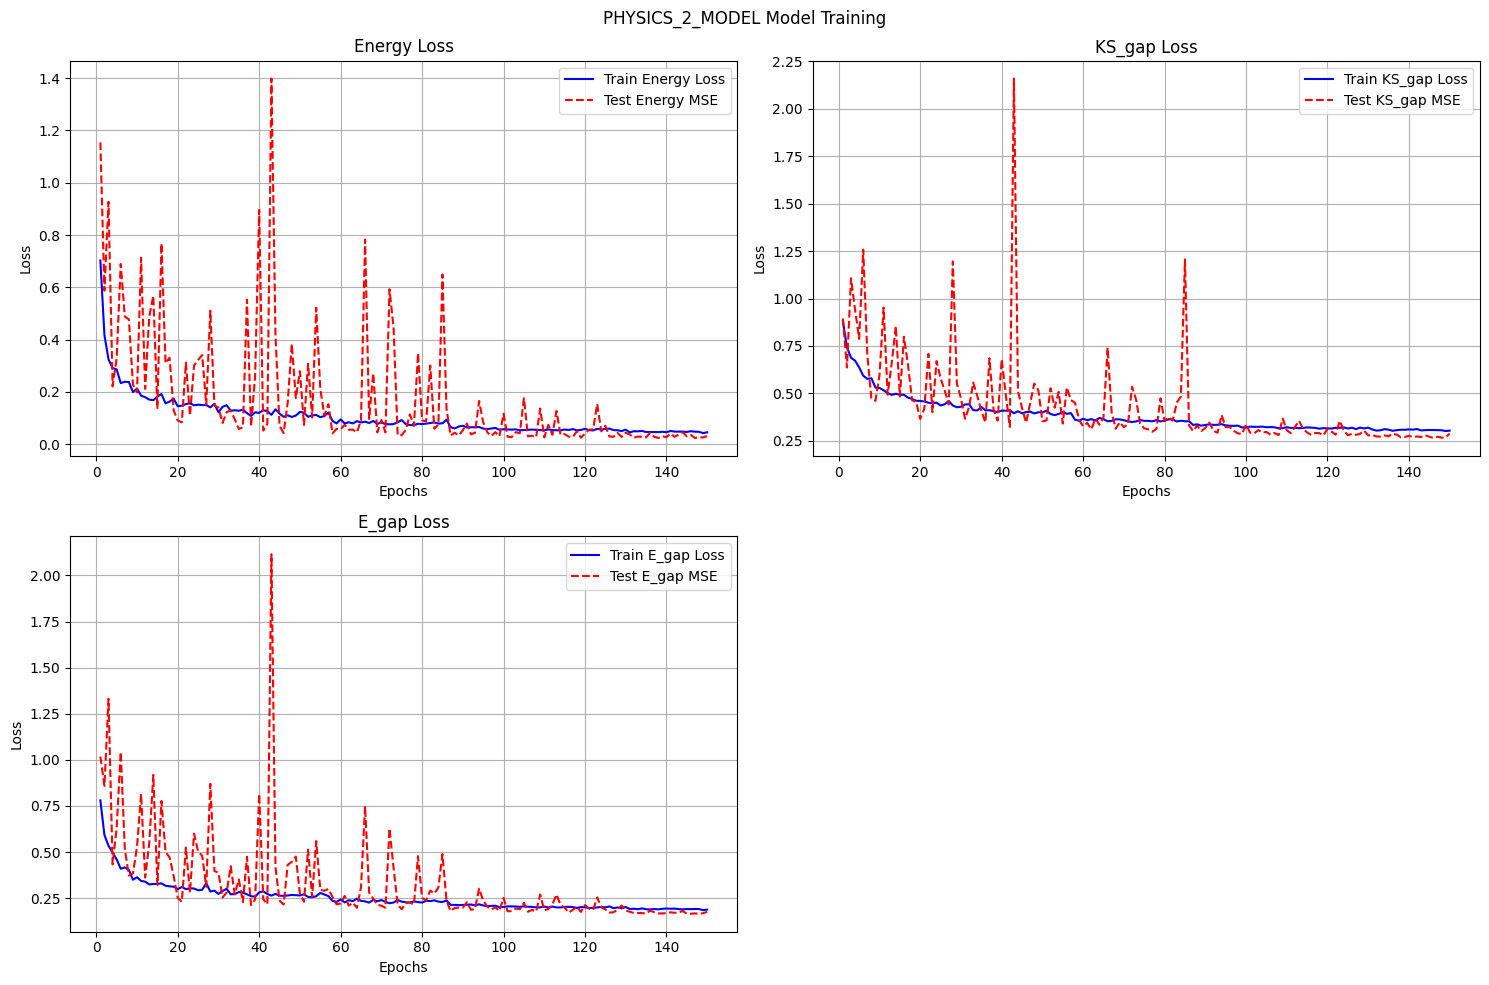

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Batch prediction results:
      energy_pred  KS_gap_pred  E_gap_pred  energy_true  KS_gap_true  \
0     -557.433228     1.551107    4.287923  -563.309095     1.623173   
1     -960.499329     1.050922    3.305808  -943.433762     1.008035   
2     -594.370056     1.531556    4.216519  -578.672957     1.557047   
3     -828.667969     1.128289    3.426533  -816.404388     1.283090   
4     -997.089294     0.859593    3.192162  -983.286795     1.345429   
...           ...          ...         ...          ...          ...   
1507  -569.100647     1.557965    4.324298  -550.219892     1.531837   
1508 -1233.550537     1.017290    3.118931 -1242.847288     1.180622   
1509 -1103.026001     1.009905    3.218621 -1086.479449     1.125403   
1510  -687.706909     1.314602    3.905923  -679.815496     1.195911   
1511  -833.909119     0.871543    3.282596  -852.353412     0.900791   

      E_gap_true  physics_valid  physics_violation  
0       4.367629           True                0.0  
1  

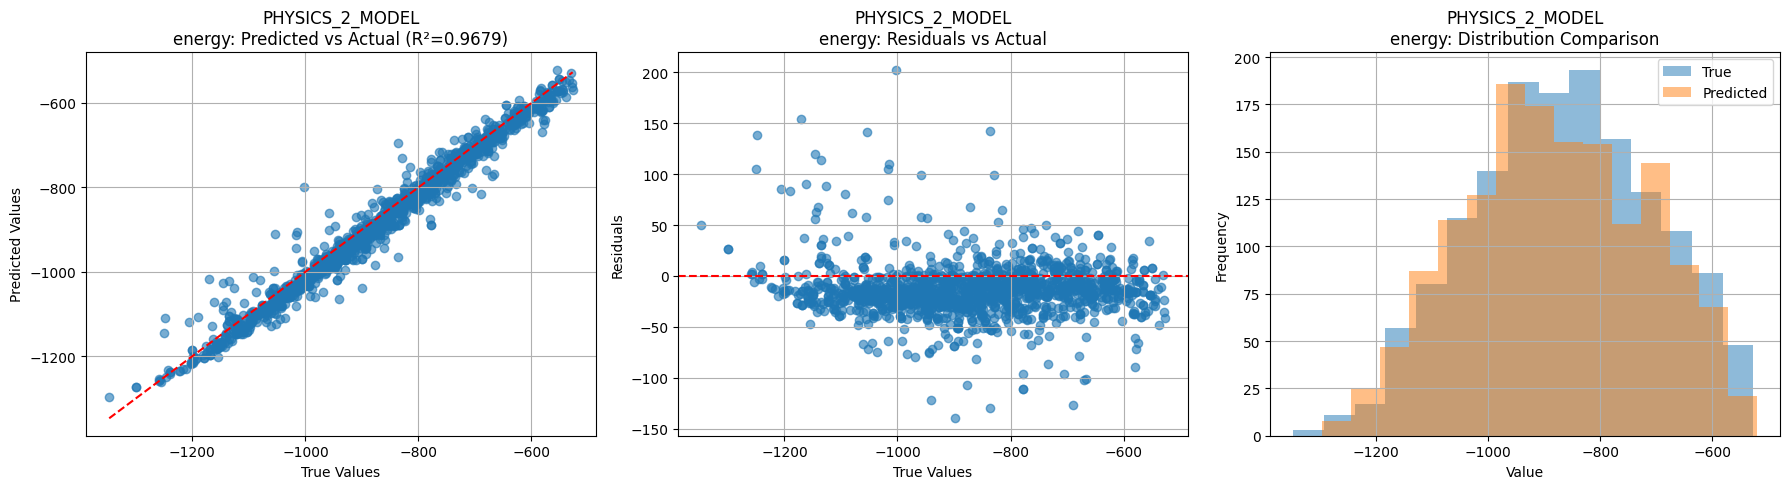

=== KS_gap Evaluation ===
Data range: 0.1257 to 1.9583 (span: 1.8326)
Mean value: 1.1287
MSE: 0.029011
RMSE: 0.170326
MAE: 0.136616
R²: 0.7154
NMSE (normalized by variance): 0.2846
Error as % of data range: 7.45%
Improvement over mean baseline: 71.54%


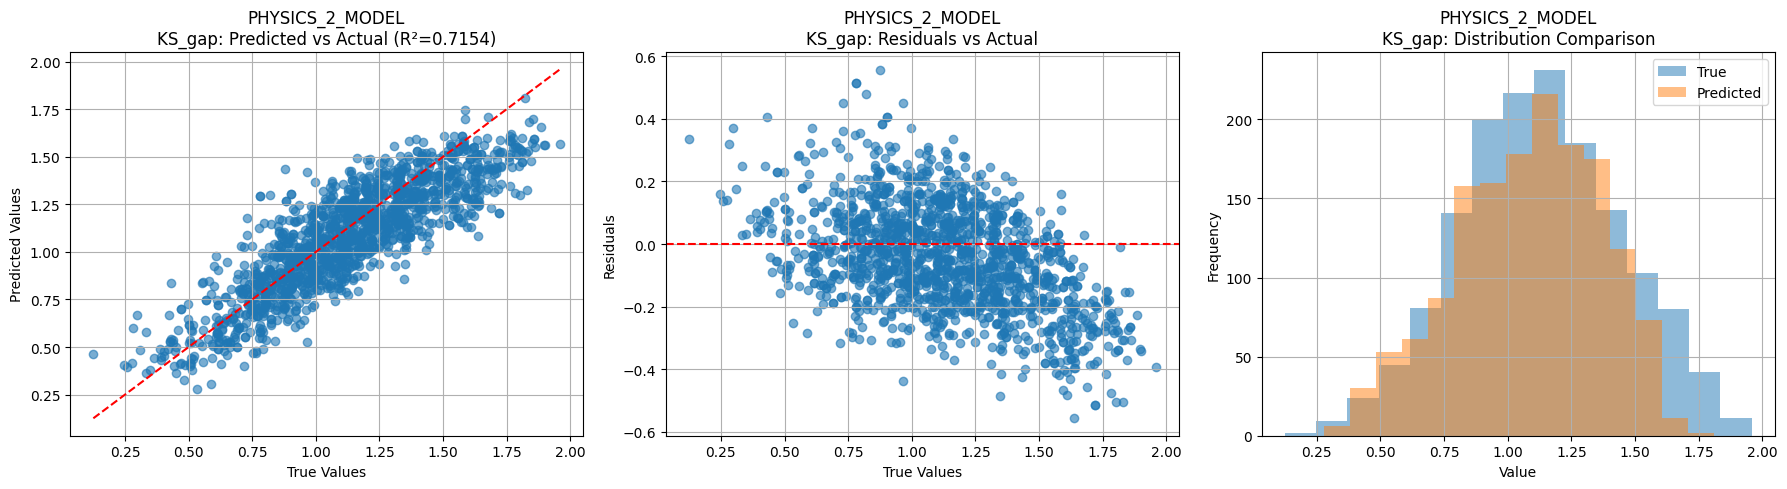

=== E_gap Evaluation ===
Data range: 2.4784 to 4.6953 (span: 2.2168)
Mean value: 3.5189
MSE: 0.033231
RMSE: 0.182295
MAE: 0.145487
R²: 0.8326
NMSE (normalized by variance): 0.1674
Error as % of data range: 6.56%
Improvement over mean baseline: 83.26%


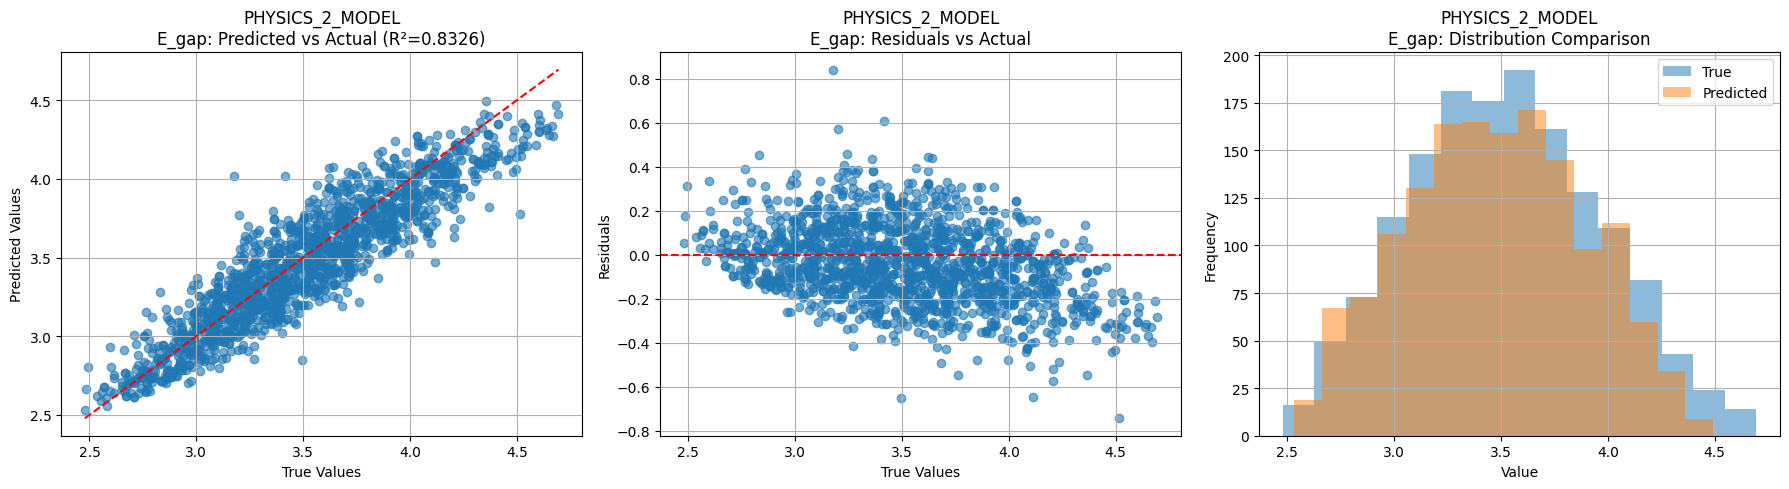

In [8]:
print("PHYSICS CONSTRAINT 2 MODEL")

save_directory = f"{path}model_outputs/"

# ensure that the directory exists
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

importlib.reload(mt)
test_name = "PHYSICS_2_MODEL"
config = {'batch_size': 32, 'epochs': 150, 'lr': 0.005, 'physics_loss_weight': 0,'nll_loss_weight': .2, 'save_path': f"{save_directory}",'save_path_model': f"{save_directory}/{test_name}_best_model.pt", 'title': test_name}
model, train_metrics, test_metrics,scalers = mt.run_training(train_df, test_df, batch_size=config['batch_size'], epochs=config['epochs'], lr=config['lr'], physics_loss_weight = config['physics_loss_weight'], nll_loss_weight = config['nll_loss_weight'], save_path=config['save_path_model'], title = config['title'])

print("Trained model")
print("Running with the following metrics:")
print(train_metrics)
print(test_metrics)

metrics_df = pd.DataFrame([train_metrics, test_metrics], columns=['Train Metrics' 'Test Metrics'])
metrics_df.to_csv(f"{config['save_path']}{config['title']}_metrics_df.csv")

mt.plot_training_performance(train_metrics, test_metrics, save_path=f"{config['save_path']}{config['title']}_model_training.png", title=f"{config['title']} Model Training")

# Load best model for inferencex
best_model = mt.GraphNet(node_dim=1, edge_dim=1, hidden_dim=64, output_dim=1)
best_model.load_state_dict(torch.load(config['save_path_model']))

# Example: Run inference on the whole holdout set
best_model = mt.load_model(config['save_path_model'])
results_df = mt.predict_batch_properties(best_model, val_df,scalers)
results_df.to_csv(f"{config['save_path']}{config['title']}_results_df.csv")
print("Batch prediction results:")
print(results_df)

# Usage example
# For each property:
data_to_save = []
for prop in ['energy', 'KS_gap', 'E_gap']:
    true_col = f'{prop}_true'
    pred_col = f'{prop}_pred'

    if true_col in results_df.columns:
        feature_metrics = mt.comprehensive_evaluation(
            results_df[true_col].values,
            results_df[pred_col].values,
            property_name=prop,
            run_name=test_name,
            save_path=f"{config['save_path']}_{config['title']}_{prop}_evaluation.png",
        )
    data_to_save.append([prop, feature_metrics])

# save the data to save  to file
data_to_save_df = pd.DataFrame(data_to_save, columns=['Property', 'Metrics'])
data_to_save_df.to_csv(f"{config['save_path']}{config['title']}_feature_metrics.csv")

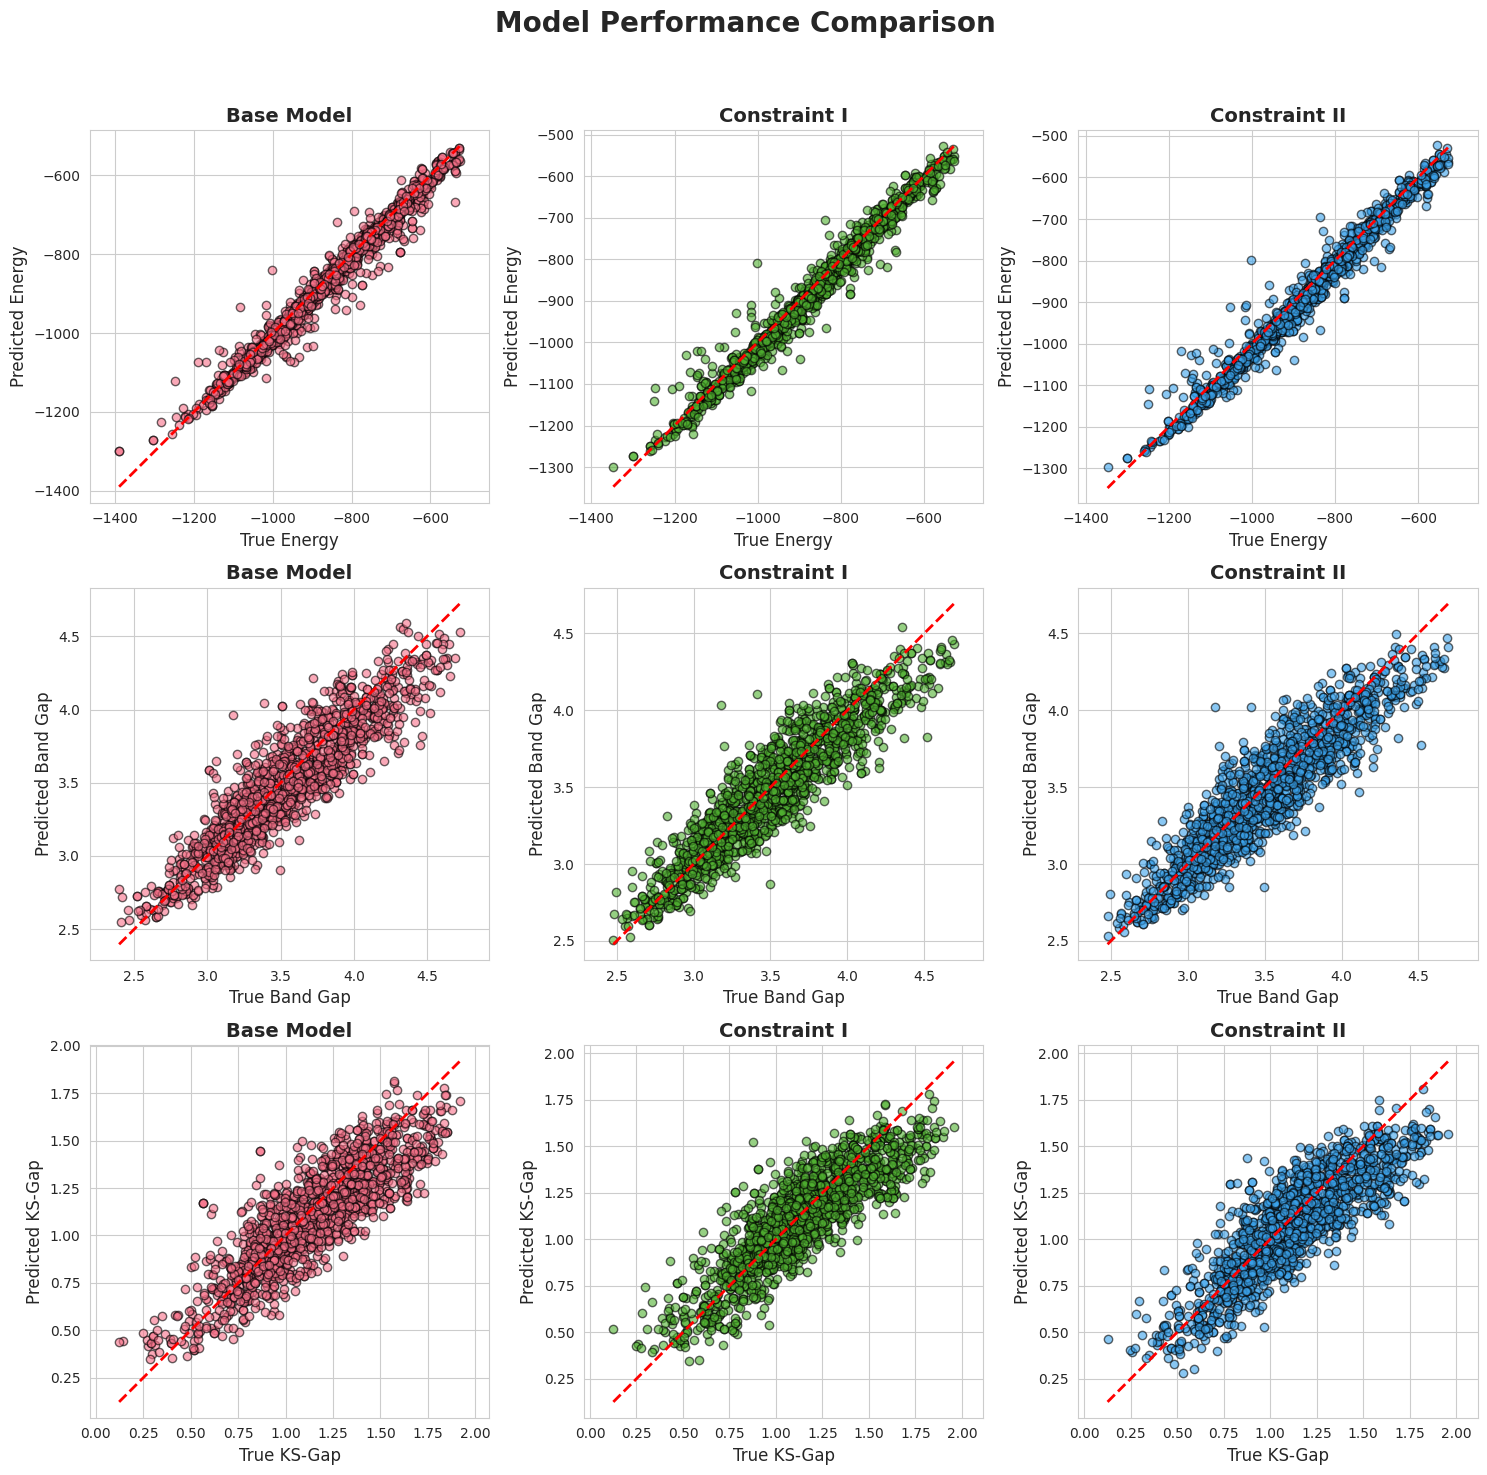

In [14]:
# prompt: make it a subplot (3x3) subplot iwth the three features on the rows and the three models being the col

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use a modern Seaborn theme
sns.set_style("whitegrid")
sns.set_palette("husl")

fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Model Performance Comparison', fontsize=20, fontweight='bold')

# Define color palette
colors = sns.color_palette("husl", 3)

feature_names = ["Energy", "Band Gap",'KS-Gap']
model_names_nice = ['Base Model', "Constraint I", "Constraint II"]
for i, prop in enumerate(['energy', 'E_gap', 'KS_gap']):
    for j, model_name in enumerate(['BASE_MODEL', 'PHYSICS_1_MODEL', 'PHYSICS_2_MODEL']):
        # Load results_df for the current model
        results_df = pd.read_csv(f"{path}model_outputs/{model_name}_results_df.csv")

        true_col = f'{prop}_true'
        pred_col = f'{prop}_pred'

        if true_col in results_df.columns and pred_col in results_df.columns:
            # Scatter plot with alpha for better visibility
            axs[i, j].scatter(results_df[true_col], results_df[pred_col], alpha=0.6, color=colors[j], edgecolors='k')

            # Perfect prediction reference line
            min_val, max_val = min(results_df[true_col]), max(results_df[true_col])
            axs[i, j].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)

            # Labels and title
            prop_nice = feature_names[i]
            model_name_nice = model_names_nice[j]
            axs[i, j].set_xlabel(f'True {prop_nice}', fontsize=12)
            axs[i, j].set_ylabel(f'Predicted {prop_nice}', fontsize=12)
            axs[i, j].set_title(f'{model_name_nice}', fontsize=14, fontweight='bold')

            # Equal aspect ratio for proper comparison
            axs[i, j].set_aspect('equal', adjustable='datalim')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
plt.subplots_adjust(top=0.9)
plt.savefig(f"{path}model_performance_comparison.png")
plt.show()

